# BPTT_realtime_withBias

In [107]:
import numpy as np

f = lambda x : 1./(1+np.exp(-x))
df = lambda x : f(x) * (1- f(x))

def fc(W_x, W_h, W_bias, x, h):
    net[:] = np.dot(W_x, x) + np.dot(W_h, h) + np.expand_dims(W_bias, axis=1)
    h[:] = f(net)
    return net, h

bp = lambda delta, W_h, h : df(h) * np.dot(W_h.T, delta)


# Reber Grammar
import random

TRANSITIONS = [
    [('T', 1), ('P', 2)],  # 0
    [('S', 1), ('X', 3)],  # 1
    [('T', 2), ('V', 4)],  # 2
    [('X', 2), ('S', 5)],  # 3
    [('V', 5), ('P', 3)],  # 4
    [('E', 6)],  # 5， 6 terminal state
]


def make_reber():
    out = 'B'
    state = 0
    while state != 6:
        ts = random.choice(TRANSITIONS[state])
        state = ts[1]
        out += ts[0]
    return out


alphabet = ['B', 'T', 'P', 'S', 'X', 'V', 'E']

# multi label training
def string_to_one_hot_array(sequence_string):
    one_hot_representation = np.zeros((len(sequence_string), len(alphabet)), dtype=np.uint8)
    next_representation = np.zeros((len(sequence_string), len(alphabet)), dtype=np.uint8)
    state = 0
    for idx, s in enumerate(sequence_string):
        one_hot_representation[idx, alphabet.index(s)] = 1
        if state != 6:
            tss = TRANSITIONS[state]
            for ts in tss:
                next_representation[idx, alphabet.index(ts[0])] = 1
                if ts[0] == sequence_string[idx + 1]: state = ts[1]

    return one_hot_representation, next_representation

# one-hot label
def string_to_one_hot_next(sequence_string):
    one_hot_representation = np.zeros((len(sequence_string), len(alphabet)), dtype=np.uint8)
    next_representation = np.zeros((len(sequence_string), len(alphabet)), dtype=np.uint8)
    for idx, s in enumerate(sequence_string):
        one_hot_representation[idx, alphabet.index(s)] = 1
    for idx in range(len(sequence_string)-1):
        next_representation[idx] = one_hot_representation[idx+1]
    return one_hot_representation, next_representation

# With bias

J:4999/0.00833584986805

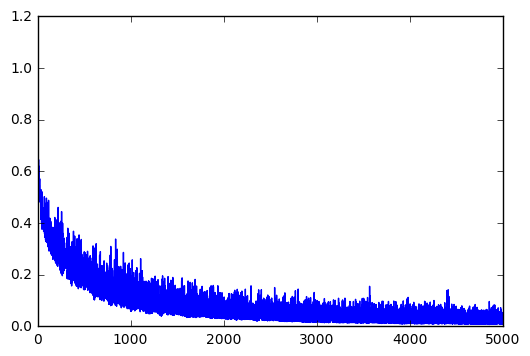

In [108]:
#######--------------------------
import sys
import matplotlib.pyplot as plt
%matplotlib inline

input_size = 7
hidden_size = 7
W_x = np.random.rand(hidden_size, input_size) * 2 - 1
W_h = np.random.rand(hidden_size, hidden_size) * 2 - 1
W_bias = np.zeros(hidden_size)

W_x_grad = np.zeros((hidden_size, input_size))
W_h_grad = np.zeros((hidden_size, hidden_size))

delta_output = np.zeros((hidden_size, 1))
delta_previous = np.zeros((hidden_size, 1))

h = np.zeros((hidden_size, 1))
net = np.zeros((hidden_size, 1))
z = np.zeros((hidden_size, 1))
y = np.zeros((hidden_size, 1))

alpha = 0.1
Jarr = []
nb_train_sequence = 5000
for seq_idx in range(nb_train_sequence):
    reber_string = make_reber()
    input_arr, target_arr = string_to_one_hot_array(reber_string)
    sequence_length = input_arr.shape[0]
    
    net_history = np.zeros((sequence_length, hidden_size, 1))
    h_history = np.zeros((sequence_length, hidden_size, 1))
    cost_sequence = 0
    
    for time_step in range(0, sequence_length-1):
        # print time_step
        # assert(0)
        x = np.expand_dims(input_arr[time_step], axis=1)
        d = np.expand_dims(target_arr[time_step], axis=1)

        # store hidden input for this time step(to calculate deltaW_h)
        h_history[time_step, :] = np.copy(h)
        
        # feedforward
        net[:], h[:] = fc(W_x, W_h, W_bias, x, h)

        # store output (to calculate df(s))
        net_history[time_step, :] = np.copy(net)

        error = h - d
        cost_sequence += 0.5 * np.sum(error ** 2)
        # print cost_sequence
        # assert(0)
        # delta at this time step
        delta_output[:] = df(net) * error

        W_x_grad = np.outer(delta_output, x)
        W_h_grad = np.outer(delta_output, h_history[time_step])
        W_x -= alpha * W_x_grad
        W_h -= alpha * W_h_grad
        W_bias -= alpha * np.squeeze(delta_output)

        # Back propagation through time (propagation delta of current time to previous time steps)
        for time_step_prev in range(time_step-1, 0, -1):
            # standard back propagation
            delta_previous = bp(delta_output, W_h, net_history[time_step_prev])
            # external input of that time
            W_x_grad = np.outer(delta_previous, np.expand_dims(input_arr[time_step_prev], axis=1))
            # hidden input of that time
            W_h_grad = np.outer(delta_previous, h_history[time_step_prev])
            W_x -= alpha * W_x_grad
            W_h -= alpha * W_h_grad
            W_bias -= alpha * np.squeeze(delta_previous)
            
            delta_output = delta_previous
            # h[:] = 0

            # if time_step==3: assert(0)
    J_avg = cost_sequence * 1.0 / sequence_length
    Jarr.append(J_avg)
    print '\rJ:{}/{}'.format(seq_idx, J_avg),
    sys.stdout.flush()
    # print np.sum(h)
    # print np.sum(error)

plt.plot(Jarr)

# Without explicit label

J:19999/0.136211199249

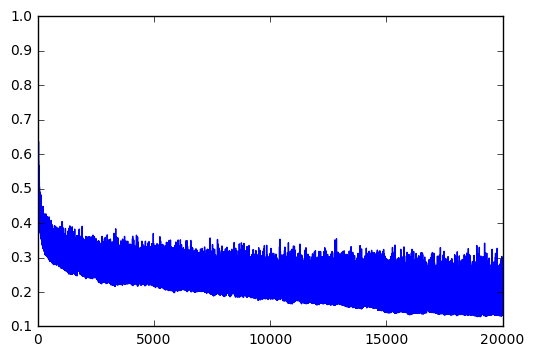

In [94]:
#######--------------------------
import sys
import matplotlib.pyplot as plt
%matplotlib inline

input_size = 7
hidden_size = 7
W_x = np.random.rand(hidden_size, input_size) * 2 - 1
W_h = np.random.rand(hidden_size, hidden_size) * 2 - 1
W_bias = np.zeros(hidden_size)

W_x_grad = np.zeros((hidden_size, input_size))
W_h_grad = np.zeros((hidden_size, hidden_size))

delta_output = np.zeros((hidden_size, 1))
delta_previous = np.zeros((hidden_size, 1))

h = np.zeros((hidden_size, 1))
net = np.zeros((hidden_size, 1))
z = np.zeros((hidden_size, 1))
y = np.zeros((hidden_size, 1))

alpha = 0.02
Jarr = []
nb_train_sequence = 20000
for seq_idx in range(nb_train_sequence):
    reber_string = make_reber()
    input_arr, target_arr = string_to_one_hot_next(reber_string)
    sequence_length = input_arr.shape[0]
    
    net_history = np.zeros((sequence_length, hidden_size, 1))
    h_history = np.zeros((sequence_length, hidden_size, 1))
    cost_sequence = 0
    
    for time_step in range(0, sequence_length-1):
        # print time_step
        # assert(0)
        x = np.expand_dims(input_arr[time_step], axis=1)
        d = np.expand_dims(target_arr[time_step], axis=1)

        # store hidden input for this time step(to calculate deltaW_h)
        h_history[time_step, :] = np.copy(h)
        
        # feedforward
        net[:], h[:] = fc(W_x, W_h, W_bias, x, h)

        # store output (to calculate df(s))
        net_history[time_step, :] = np.copy(net)

        error = h - d
        cost_sequence += 0.5 * np.sum(error ** 2)
        # print cost_sequence
        # assert(0)
        # delta at this time step
        delta_output[:] = df(net) * error

        W_x_grad = np.outer(delta_output, x)
        W_h_grad = np.outer(delta_output, h_history[time_step])
        W_x -= alpha * W_x_grad
        W_h -= alpha * W_h_grad
        W_bias -= alpha * np.squeeze(delta_output)

        # Back propagation through time (propagation delta of current time to previous time steps)
        for time_step_prev in range(time_step-1, 0, -1):
            # standard back propagation
            delta_previous = bp(delta_output, W_h, net_history[time_step_prev])
            # external input of that time
            W_x_grad = np.outer(delta_previous, np.expand_dims(input_arr[time_step_prev], axis=1))
            # hidden input of that time
            W_h_grad = np.outer(delta_previous, h_history[time_step_prev])
            W_x -= alpha * W_x_grad
            W_h -= alpha * W_h_grad
            W_bias -= alpha * np.squeeze(delta_previous)
            
            delta_output = delta_previous
            # h[:] = 0

            # if time_step==3: assert(0)
    J_avg = cost_sequence * 1.0 / sequence_length
    Jarr.append(J_avg)
    print '\rJ:{}/{}'.format(seq_idx, J_avg),
    sys.stdout.flush()
    # print np.sum(h)
    # print np.sum(error)

plt.plot(Jarr)

# Test

In [111]:
testLength = 100
correctNum = 0


h = np.zeros((hidden_size, 1))
net = np.zeros((hidden_size, 1))

for seq_idx in range(testLength):
    reber_string = make_reber()
    input_arr, target_arr = string_to_one_hot_array(reber_string)
    sequence_length = input_arr.shape[0]

    flag=True
    for time_step in range(0, sequence_length-1):
        # print time_step
        # assert(0)
        x = np.expand_dims(input_arr[time_step], axis=1)
        d = np.expand_dims(target_arr[time_step], axis=1)
        
        # feedforward
        net[:], h[:] = fc(W_x, W_h, W_bias, x, h)
        
        yThreshold = np.zeros(h.shape)
        yThreshold[np.where(h>0.5)] = 1
        t = target_arr[time_step, :]
        # print h
        # print t
        if np.sum(np.squeeze(yThreshold) - t)!=0:
            flag = False
    if flag==True:
        correctNum += 1
        
print('correct:{}/{}'.format(correctNum, testLength))

correct:100/100
